<a href="https://colab.research.google.com/github/TuskiNinjaa/camera-helmet-detection/blob/main/TPI_Trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image, ImageDraw, ImageStat, ImageOps
import cv2
import torch
from mmdet.apis import init_detector, inference_detector, async_inference_detector
import mmcv

from tqdm.notebook import tqdm

In [ ]:
# Check Pytorch installation
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

import mmcv
print(mmcv.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

print(cv2.__version__)

2.0.1 True
3.2.0
2.0.1
11.8
GCC 9.3
4.7.0


In [ ]:
main_directory = "data"
folder_image = "/images"
folder_label = "/labels"
folder_test = "/test/"
folder_train = "/train/"
folder_valid = "/valid/"

In [ ]:
def info_folder(dir):
    print(len(os.listdir(dir)))

In [ ]:
info_folder(main_directory+folder_image+folder_train)
info_folder(main_directory+folder_image+folder_test)
info_folder(main_directory+folder_image+folder_valid)
info_folder(main_directory+folder_label+folder_train)
info_folder(main_directory+folder_label+folder_test)
info_folder(main_directory+folder_label+folder_valid)

15887
2261
4641
15888
2262
4642


## Convert annotations to COCO format

In [ ]:
#Função que cria uma pasta de nome "folder_name" no diretorio "directory"
def create_folder(directory, folder_name):
    directory = os.path.join(directory, folder_name)
    try:
        os.mkdir(directory)
    except OSError:
        print ("Creation of the folder '%s' failed" % folder_name)
    else:
        print ("Creation of the folder '%s' succeded" % folder_name)

    return directory

#Função que cria o dicionário com as info de todas as imagens e anotações
def create_dictionary_json(classes):
    dictionary_json = {
        "images" : [],
        "type" : "instances",
        "annotations" : [],
        "categories": []
    }

    for i in range(len(classes)):
        category = {
            'id' : i,
            'name' : classes[i],
            'supercategory' : classes[i]
        }
        dictionary_json['categories'].append(category)

    return dictionary_json

#Função que salva o dicionário no diretório informado
def save_dictionary_json(directory, file_name, dictionary):
    with open(os.path.join(directory, file_name)+".json", 'w', encoding = 'utf-8') as file:
        json.dump(dictionary, file, ensure_ascii = False, indent=4)

In [ ]:
def create_coco(main_directory, folder_image, folder_label, folder, classes, output_name):
    image_dir = main_directory+folder_image+folder
    label_dir = main_directory+folder_label+folder

    dictionary = create_dictionary_json(classes)
    bbox_id = 0
    for image_id, f in tqdm(enumerate(os.listdir(image_dir))):
        img = Image.open(image_dir+f)
        w, h = img.size
        file_name, file_extention = os.path.splitext(f)

        image = {
            "id": image_id,
            "width": w,
            "height": h,
            "file_name": f,
        }
        dictionary['images'].append(image)

        with open(label_dir+file_name+".txt", "r") as file_ann:
            for line in file_ann:
                line_arguments = line.split(" ")
                c, x, y, width, height = [float(i) for i in line_arguments]

                x0 = (w*(x-width/2))
                y0 = (h*(y-height/2))
                x1 = (w*(x+width/2))
                y1 = (h*(y+height/2))

                annotation = {
                    "id": bbox_id,
                    "image_id": image_id,
                    "category_id": int(c),
                    "segmentation": [],
                    "area": (x1-x0)*(y1-y0),
                    "bbox": [x0,y0,(x1-x0),(y1-y0)],
                    "iscrowd": 0,
                }

                dictionary['annotations'].append(annotation)
                bbox_id += 1

    save_dictionary_json(label_dir, output_name, dictionary)

In [ ]:
folders = [folder_train, folder_valid ,folder_test]
output_names = ["train", "val", "test"]
for i in range(len(folders)):
    create_coco(main_directory, folder_image, folder_label, folders[i], classes=["helmet","head"], output_name=output_names[i])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Saving test images with prediction with threshold = 0.5

In [ ]:
directory_bbox_result = "/home/yuske/Documentos/Projects/mmdetection/work_dirs/faster_rcnn_coco_helmet/test.bbox.json"
directory_test_labels = main_directory+folder_label+folder_test+"test.json"
directory_test_images = main_directory+folder_image+folder_test
directory_output = "/home/yuske/Documentos/Projects/TPI-trabalho-final/faster_rcnn_test_images/"

In [ ]:
test_bbox = json.load(open(directory_bbox_result, 'r', encoding = 'utf-8'))
test_dataset = json.load(open(directory_test_labels, 'r', encoding = 'utf-8'))

i = 0
for image_id, test_image in enumerate(tqdm(test_dataset["images"])):
    img = Image.open(directory_test_images+test_image["file_name"])

    while image_id == test_bbox[i]["image_id"]:
        bbox = test_bbox[i]["bbox"]
        c = test_bbox[i]["category_id"]
        score = test_bbox[i]["score"]

        if score > 0.5:
            color = "red" if int(c) == 0 else "blue"
            img1 = ImageDraw.Draw(img)
            img1.rectangle([bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]], outline =color, width=int(img.size[0]/100))

        i += 1
        if i == len(test_bbox):
            break

    img.save(directory_output+test_image["file_name"])
    # img = np.array(img)
    # plt.imshow(img)
    # plt.show()

  0%|          | 0/2261 [00:00<?, ?it/s]

## Inference

In [ ]:
def plot_results(result, image, threshold, directory_output, thickness=3):
    bboxes = result.pred_instances.bboxes.cpu().data.numpy().astype(int)
    labels = result.pred_instances.labels.cpu().data.numpy()
    scores = result.pred_instances.scores.cpu().data.numpy()

    for i, bbox in enumerate(bboxes):
        if scores[i] > threshold:
            color = (255,0,0) if labels[i] == 1 else (0,0,255)
            image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)

    cv2.imwrite(directory_output, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

In [ ]:
def draw_inference(result, image, threshold, thickness=3):
    bboxes = result.pred_instances.bboxes.cpu().data.numpy().astype(int)
    labels = result.pred_instances.labels.cpu().data.numpy()
    scores = result.pred_instances.scores.cpu().data.numpy()

    for i, bbox in enumerate(bboxes):
        if scores[i] > threshold:
            color = (255,0,0) if labels[i] == 1 else (0,0,255)
            image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)

    return image

Loads checkpoint by local backend from path: /home/yuske/Documentos/Projects/mmdetection/work_dirs/save_faster-rcnn_r50_fpn_1x_helmet/epoch_9.pth


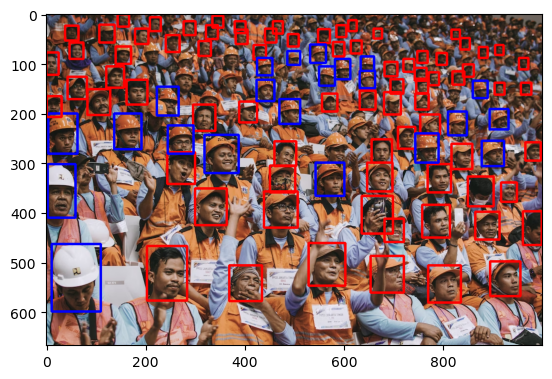

In [ ]:
# Specify the path to model config and checkpoint file
config_file = '/home/yuske/Documentos/Projects/mmdetection/work_dirs/save_faster-rcnn_r50_fpn_1x_helmet/faster-rcnn_r50_fpn_1x_helmet.py'
checkpoint_file = '/home/yuske/Documentos/Projects/mmdetection/work_dirs/save_faster-rcnn_r50_fpn_1x_helmet/epoch_9.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# test a single image and show the results
image = mmcv.imread('/home/yuske/Downloads/pessoas0.png')
directory_output = '/home/yuske/Downloads/pessoas0_out.png'
result = inference_detector(model, image)

plot_results(result, image, 0.5, directory_output)